In [83]:
import tensorflow_recommenders as tfrs
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics.pairwise import cosine_distances
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import math

In [271]:
rating = tfds.load('movielens/100k-ratings', split='train')
# features of all the movies
movies = tfds.load('movielens/100k-movies', split='train')

In [67]:
user_ids = []
movie_ids = []
ratings = []

for data in rating:
    user_ids.append(data['user_id'].numpy())
    movie_ids.append(data['movie_id'].numpy())
    ratings.append(data['user_rating'].numpy())

data_dict = {'userId': user_ids, 'movieId': movie_ids, 'rating': ratings}
df = pd.DataFrame(data_dict)

,userId,movieId,rating
0,b'138',b'357',4.0
1,b'92',b'709',2.0
2,b'301',b'412',4.0
3,b'60',b'56',4.0
4,b'197',b'895',3.0


In [277]:
title = []
movie_ids = []
genres = []

for data in movies:
    movie_ids.append(data['movie_id'].numpy())
    title.append(data['movie_title'].numpy())
    genres.append(data['movie_genres'].numpy())

data_dict = {'movieId': movie_ids, 'title': title, 'genres': genres}
movie_df = pd.DataFrame(data_dict)
movie_df.head()

,movieId,title,genres
0,b'1681',b'You So Crazy (1994)',[4]
1,b'1457',b'Love Is All There Is (1996)',"[4, 7]"
2,b'500',b'Fly Away Home (1996)',"[1, 3]"
3,b'838',b'In the Line of Duty 2 (1987)',[0]
4,b'1648',"b'Niagara, Niagara (1997)'",[7]


In [274]:
def decode_bytes(byte_literal):
    return byte_literal.decode() if isinstance(byte_literal, bytes) else byte_literal

def decode_bytes_and_convert_to_int(byte_literal):
    decoded_str = byte_literal.decode() if isinstance(byte_literal, bytes) else byte_literal
    return int(decoded_str)

In [280]:
df = df.applymap(decode_bytes)
df['userId'] = df['userId'].astype(int)
df['movieId'] = df['movieId'].astype(int)
df.head()

,userId,movieId,rating
0,138,357,4.0
1,92,709,2.0
2,301,412,4.0
3,60,56,4.0
4,197,895,3.0


In [281]:
movie_df = movie_df.applymap(decode_bytes)
movie_df['movieId'] = movie_df['movieId'].astype(int)
movie_df.head()

,movieId,title,genres
0,1681,You So Crazy (1994),[4]
1,1457,Love Is All There Is (1996),"[4, 7]"
2,500,Fly Away Home (1996),"[1, 3]"
3,838,In the Line of Duty 2 (1987),[0]
4,1648,"Niagara, Niagara (1997)",[7]


In [68]:
rating = rating.map(lambda x:{'movie_title':x['movie_title'],'user_id':x['user_id']})
movies = movies_df.map(lambda x: x['movie_title'])

In [ ]:
user_id_vocabulary = tf.keras.layers.experimental.preprocessing.StringLookup(mask_token=None)
user_id_vocabulary.adapt(rating.map(lambda x: x['user_id']))

In [166]:
movie_ids = np.vectorize(decode_bytes_and_convert_to_int)(np.unique(np.unique(df['movieId'])))
user_ids = np.vectorize(decode_bytes_and_convert_to_int)(np.unique(df['userId']))

num_users = len(user_ids)
num_movies = len(movie_ids)

In [70]:
movies_title_vocabulary = tf.keras.layers.experimental.preprocessing.StringLookup(mask_token=None)
movies_title_vocabulary.adapt(movies)

In [71]:
class MovieLensModel(tfrs.Model):

  def __init__(
      self,
      user_model: tf.keras.Model,
      movie_model: tf.keras.Model,
      task: tfrs.tasks.Retrieval):
    super().__init__()

    # Set up user and movie representations.
    self.user_model = user_model
    self.movie_model = movie_model

    # Set up a retrieval task.
    self.task = task

  def compute_loss(self, features: dict[str,tf.Tensor], training=False) -> tf.Tensor:
    # Define how the loss is computed.

    user_embeddings = self.user_model(features["user_id"])
    movie_embeddings = self.movie_model(features["movie_title"])

    return self.task(user_embeddings, movie_embeddings)

In [72]:
users_embedding = tf.keras.layers.Embedding(user_id_vocabulary.vocabulary_size(),64)
movie_embedding = tf.keras.layers.Embedding(movies_title_vocabulary.vocabulary_size(),64)
users_model = tf.keras.Sequential([user_id_vocabulary,users_embedding])
movie_model = tf.keras.Sequential([movies_title_vocabulary,movie_embedding])

task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(movies.batch(128).map(movie_model)))

In [73]:
model = MovieLensModel(users_model,movie_model,task)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.5))
model.fit(rating.batch(4096), epochs=5)

Epoch 1/5
25/25 [==============================] - 26s 969ms/step - factorized_top_k/top_1_categorical_accuracy: 1.0000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0020 - factorized_top_k/top_10_categorical_accuracy: 0.0060 - factorized_top_k/top_50_categorical_accuracy: 0.0509 - factorized_top_k/top_100_categorical_accuracy: 0.1111 - loss: 33072.2261 - regularization_loss: 0.0000e+00 - total_loss: 33072.2261
Epoch 2/5
25/25 [==============================] - 23s 934ms/step - factorized_top_k/top_1_categorical_accuracy: 3.5000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0057 - factorized_top_k/top_10_categorical_accuracy: 0.0161 - factorized_top_k/top_50_categorical_accuracy: 0.1085 - factorized_top_k/top_100_categorical_accuracy: 0.2135 - loss: 31010.0770 - regularization_loss: 0.0000e+00 - total_loss: 31010.0770
Epoch 3/5
25/25 [==============================] - 23s 930ms/step - factorized_top_k/top_1_categorical_accuracy: 7.8000e-04 - factorized_top_k/top_5_categor

In [74]:
recommends = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
recommends.index_from_dataset(movies.batch(100).map(lambda title: (title, model.movie_model(title))))

In [215]:
target_user_id = 138

In [75]:
def get_recommended_movies(user_id,n):
  _, titles = recommends(np.array([str(user_id)]))
  return titles[0,:n]

In [76]:
user_embeddings = users_embedding.get_weights()[0]
similarity_matrix = 1 - cosine_distances(users_embedding.get_weights()[0])

In [77]:
similarity_matrix_pd = pd.DataFrame(similarity_matrix)
similarity_matrix_pd

,0,1,2,3,4,5,6,7,8,9,...,934,935,936,937,938,939,940,941,942,943
0,1.000000,0.261720,-0.041351,0.166456,0.186087,0.006518,-0.174170,0.022211,-0.018652,0.114862,...,0.015273,-0.153932,-0.148799,-0.315647,-0.217276,-0.239615,-0.229045,-0.144555,-0.319316,-0.219397
1,0.261720,1.000000,0.151239,0.139929,-0.024530,0.204180,0.042397,0.331090,-0.027021,0.012349,...,-0.080098,-0.085743,-0.428612,-0.292483,-0.193629,-0.300075,-0.006278,-0.156399,-0.351292,-0.288604
2,-0.041351,0.151239,1.000000,0.005350,-0.108562,-0.082126,-0.073304,0.193308,0.057471,0.043173,...,-0.036917,-0.036397,0.082273,-0.325193,0.101267,-0.165983,-0.145705,-0.317985,-0.007870,-0.105504
3,0.166456,0.139929,0.005350,1.000000,-0.015512,-0.100623,0.078326,-0.036962,-0.076221,0.102257,...,0.247469,0.305005,0.099721,-0.086458,-0.009155,-0.120855,-0.205290,0.086090,0.115614,0.001467
4,0.186087,-0.024530,-0.108562,-0.015512,1.000000,-0.091082,0.142564,-0.100133,-0.093190,0.260841,...,-0.101565,-0.064799,-0.121912,-0.185884,-0.226787,0.137450,-0.127271,0.012689,-0.083193,-0.083506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,-0.239615,-0.300075,-0.165983,-0.120855,0.137450,-0.462648,-0.242348,-0.050618,-0.273510,0.148402,...,0.061854,0.173307,0.222169,0.048195,0.119355,1.000000,0.247297,0.142683,0.257909,0.185214
940,-0.229045,-0.006278,-0.145705,-0.205290,-0.127271,0.037613,-0.207075,-0.088365,-0.146771,0.206686,...,0.115774,0.060439,0.225746,0.191145,-0.048889,0.247297,1.000000,0.075243,0.135991,0.237365
941,-0.144555,-0.156399,-0.317985,0.086090,0.012689,-0.088288,-0.225037,0.201122,-0.292803,-0.088807,...,0.209686,0.387373,0.246487,0.303209,0.117262,0.142683,0.075243,1.000000,0.496199,0.487328
942,-0.319316,-0.351292,-0.007870,0.115614,-0.083193,-0.211730,-0.117860,0.036686,-0.251910,-0.146254,...,0.261977,0.463450,0.428230,0.086729,0.295536,0.257909,0.135991,0.496199,1.000000,0.502547


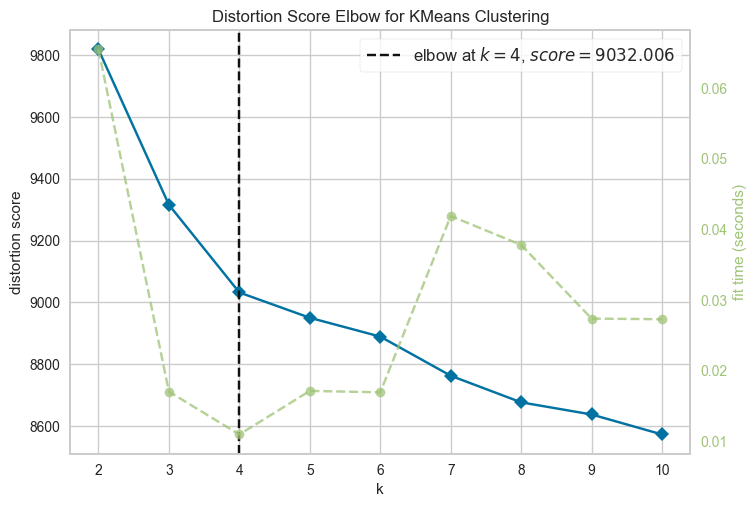

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [78]:
k_means_test = KMeans(random_state = 42,n_init='auto')
elb_visualizer = KElbowVisualizer(k_means_test, k=(2,11))
elb_visualizer.fit(user_embeddings)
elb_visualizer.show()

In [256]:
n_clusters = int(elb_visualizer.elbow_value_)
k_means = KMeans(n_clusters = n_clusters, random_state=42,n_init='auto').fit(user_embeddings)

In [201]:
def TF_IDF():
    top_10_fav_movies = df.groupby(['userId']).apply(lambda x: x.sort_values(["rating"],ascending=False).head(10))['movieId']
    res = dict()
    for movie in movie_ids:
        if top_10_fav_movies.value_counts().get(movie) is not None:
            res[movie] = (df['movieId'].value_counts().get(movie) / len(df)) * \
                         math.log(num_users/ top_10_fav_movies.value_counts().get(movie))
        else: res[movie] = 0.003
    return res

In [202]:
TF_IDF_matrix = TF_IDF()
TF_IDF_matrix

{1: 0.009969870315955571,
 10: 0.010257857548550657,
 100: 0.007877513293350607,
 1000: 0.003,
 1001: 0.003,
 1002: 0.003,
 1003: 0.003,
 1004: 0.003,
 1005: 0.003,
 1006: 0.003,
 1007: 0.003,
 1008: 0.003,
 1009: 0.003,
 101: 0.007841211388772954,
 1010: 0.003,
 1011: 0.003,
 1012: 0.003,
 1013: 0.003,
 1014: 0.003,
 1015: 0.003,
 1016: 0.003,
 1017: 0.003,
 1018: 0.003,
 1019: 0.003,
 102: 0.0078049094841953015,
 1020: 0.003,
 1021: 0.003,
 1022: 0.003,
 1023: 0.003,
 1024: 0.003,
 1025: 0.003,
 1026: 0.003,
 1027: 0.003,
 1028: 0.003,
 1029: 0.003,
 103: 0.007732305675039996,
 1030: 0.003,
 1031: 0.003,
 1032: 0.003,
 1033: 0.003,
 1034: 0.003,
 1035: 0.003,
 1036: 0.003,
 1037: 0.003,
 1038: 0.003,
 1039: 0.003,
 104: 0.007696003770462344,
 1040: 0.003,
 1041: 0.003,
 1042: 0.003,
 1043: 0.003,
 1044: 0.003,
 1045: 0.003,
 1046: 0.003,
 1047: 0.003,
 1048: 0.003,
 1049: 0.003,
 105: 0.00774583627432243,
 1050: 0.003,
 1051: 0.003,
 1052: 0.003,
 1053: 0.003,
 1054: 0.003,
 1055: 0.

In [205]:
def get_recommended_movies_for_cluster(target_cluster):
    movies_dict = dict()
    users_cluster = np.where(k_means.labels_ == target_cluster)[0] + 1
    num_users_cluster = len(users_cluster)
    top_20_fav_movies = df.groupby(['userId']).apply(lambda x: x.sort_values(["rating"],ascending=False).head(20))
    top_20_fav_movies.reset_index(drop=True, inplace=True)
    top_20_fav_movies['movieId'] = top_20_fav_movies['movieId'].astype(int)
    top_20_fav_movies['userId'] = top_20_fav_movies['userId'].astype(int)
    for movie_id in movie_ids:
        sum_ratings = sum(top_20_fav_movies[(top_20_fav_movies.userId.isin(users_cluster)) &
                                            (top_20_fav_movies.movieId == movie_id)]['rating'].astype(int))
        if(sum_ratings != 0):
            movies_dict[movie_id] = (sum_ratings * TF_IDF_matrix[movie_id]) / num_users_cluster
    movies_dict = {k: v for k, v in sorted(movies_dict.items(), key=lambda item: item[1],reverse=True)}
    return movies_dict

In [206]:
get_recommended_movies_for_cluster(0)

{50: 0.013083257424091176,
 100: 0.008603551384903659,
 12: 0.007338527871988427,
 127: 0.006831347759127861,
 56: 0.006611721922259656,
 7: 0.006319444071816776,
 1: 0.006294342088875176,
 258: 0.005771713643936536,
 9: 0.005413107566157657,
 181: 0.0050699776614802836,
 172: 0.005051826477147776,
 98: 0.004928730086337469,
 286: 0.004901943362799432,
 174: 0.0045288350703212325,
 313: 0.004502769374651855,
 173: 0.004308479854729445,
 22: 0.00425790149342389,
 14: 0.004159715245100187,
 302: 0.004061873972941148,
 300: 0.003959008333366665,
 64: 0.003958613454471021,
 288: 0.003728879434575032,
 96: 0.003696547564753102,
 269: 0.003668309459034393,
 318: 0.003407354584993475,
 191: 0.003137329713329829,
 272: 0.00310904801662622,
 294: 0.0029826639509097073,
 117: 0.002909437803309787,
 89: 0.002871729839117127,
 185: 0.0028090210470110583,
 23: 0.0027134986352467935,
 8: 0.002706300313103926,
 275: 0.002606369132637237,
 124: 0.0025849859193250485,
 151: 0.002571144729569004,
 135: 

In [223]:
def top_n_similar_users(user_id,n):
    return np.argsort(np.delete(similarity_matrix[user_id - 1],user_id - 1))[-n:] + 1

In [250]:
n = 10
similar_users = top_n_similar_users(target_user_id,n)
movies_watched_by_user = df[df.userId == target_user_id]
df_user = movies_watched_by_user[['movieId', 'rating']]

for similar_user_id in similar_users:
    rmse = 0
    movies_watched_by_similar_user = df[df.userId == similar_user_id]
    df_similar_user = movies_watched_by_similar_user[['movieId', 'rating']]
    corresponding_movie_ids = df_similar_user[df_similar_user.movieId.isin(df_user.movieId)]['movieId']
    for movie_id in corresponding_movie_ids:
        rmse += math.pow(df_user[df_user.movieId == movie_id].iloc[0]['rating'] -
                         df_similar_user[df_similar_user.movieId == movie_id].iloc[0]['rating'],2)
    rmse = math.sqrt(rmse*1/n)
    print(str(rmse) + str(corresponding_movie_ids.shape))

0.0(0,)
1.3416407864998738(10,)
0.0(0,)
1.61245154965971(5,)
2.2135943621178655(18,)
0.0(0,)
0.5477225575051661(13,)
1.0488088481701516(29,)
0.0(0,)
0.7745966692414834(4,)


In [257]:
def get_recommended_movies_for_all_clusters():
    movies_for_clusters = dict()
    for i in range(n_clusters):
        movies_for_clusters[i] = get_recommended_movies_for_cluster(i)
    return movies_for_clusters

In [258]:
%%capture
movies_for_clusters = get_recommended_movies_for_all_clusters()

In [259]:
movies_for_clusters

{0: {50: 0.013083257424091176,
  100: 0.008603551384903659,
  12: 0.007338527871988427,
  127: 0.006831347759127861,
  56: 0.006611721922259656,
  7: 0.006319444071816776,
  1: 0.006294342088875176,
  258: 0.005771713643936536,
  9: 0.005413107566157657,
  181: 0.0050699776614802836,
  172: 0.005051826477147776,
  98: 0.004928730086337469,
  286: 0.004901943362799432,
  174: 0.0045288350703212325,
  313: 0.004502769374651855,
  173: 0.004308479854729445,
  22: 0.00425790149342389,
  14: 0.004159715245100187,
  302: 0.004061873972941148,
  300: 0.003959008333366665,
  64: 0.003958613454471021,
  288: 0.003728879434575032,
  96: 0.003696547564753102,
  269: 0.003668309459034393,
  318: 0.003407354584993475,
  191: 0.003137329713329829,
  272: 0.00310904801662622,
  294: 0.0029826639509097073,
  117: 0.002909437803309787,
  89: 0.002871729839117127,
  185: 0.0028090210470110583,
  23: 0.0027134986352467935,
  8: 0.002706300313103926,
  275: 0.002606369132637237,
  124: 0.00258498591932504

In [283]:
%%capture
genres_recommended_for_all_clusters = dict()
genres_recommended_tmp = dict()
for cluster in movies_for_clusters.keys():
    num_users_cluster = len(np.where(k_means.labels_ == cluster)[0])
    for movie in movies_for_clusters[cluster].keys():
        for genre in movie_df[movie_df['movieId'] == movie].iloc[0]['genres']:
            if(genre in genres_recommended_tmp.keys()):
                genres_recommended_tmp[genre] = genres_recommended_tmp[genre] + 1
            else: genres_recommended_tmp[genre] = 1
    genres_recommended_tmp = {k: v for k, v in sorted(genres_recommended_tmp.items(), key=lambda item: item[1],reverse=True)}
    for key in genres_recommended_tmp.keys():
        genres_recommended_tmp[key] = (genres_recommended_tmp[key]/num_users_cluster)
    genres_recommended_for_all_clusters[cluster] = genres_recommended_tmp
    genres_recommended_tmp = dict()

In [288]:
genres_recommended_for_all_clusters[0]

{7: 1.5714285714285714,
 4: 1.064516129032258,
 16: 0.6912442396313364,
 14: 0.6820276497695853,
 0: 0.6589861751152074,
 1: 0.37327188940092165,
 15: 0.34101382488479265,
 5: 0.2672811059907834,
 18: 0.24423963133640553,
 3: 0.24423963133640553,
 10: 0.21658986175115208,
 13: 0.2073732718894009,
 12: 0.16589861751152074,
 2: 0.14285714285714285,
 9: 0.06912442396313365,
 19: 0.06451612903225806,
 6: 0.055299539170506916,
 8: 0.041474654377880185}

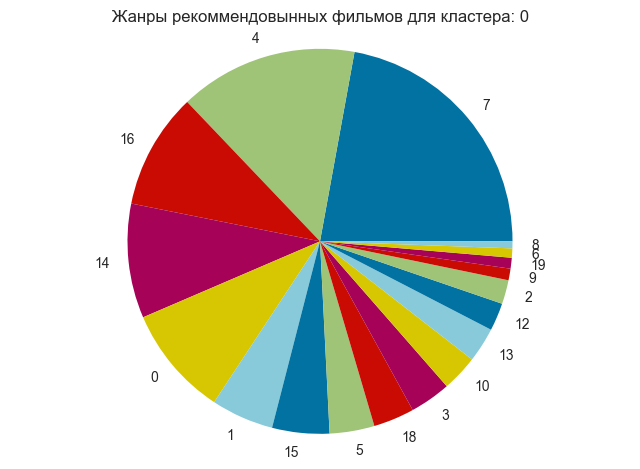

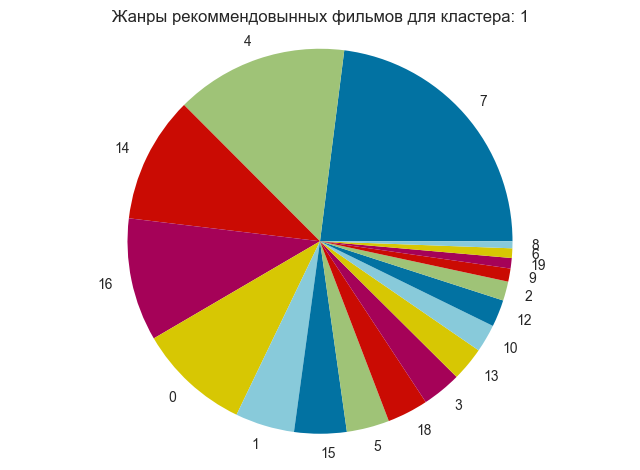

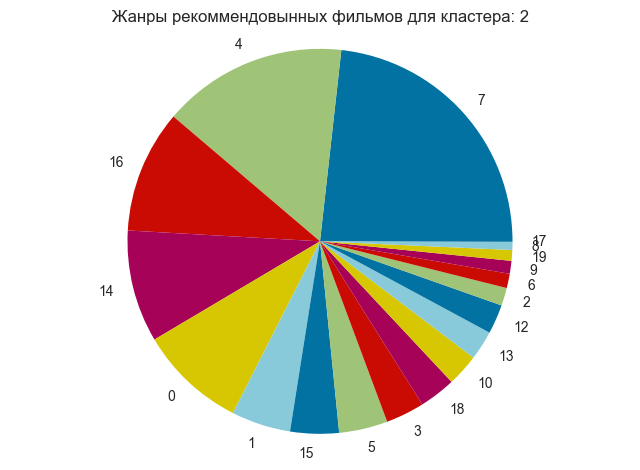

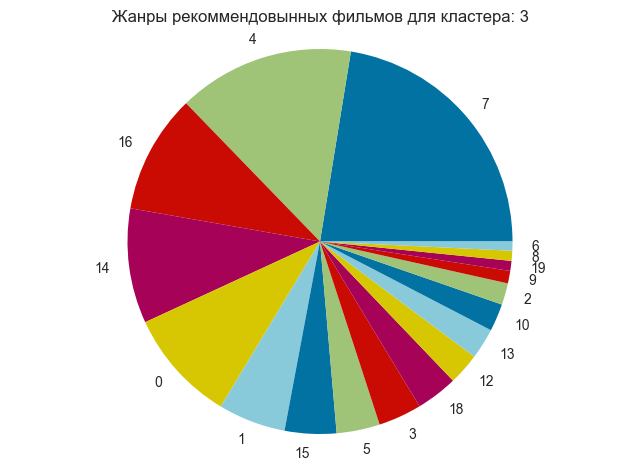

In [285]:
for i in genres_recommended_for_all_clusters.keys():
    labels = []
    sizes = []
    for x, y in genres_recommended_for_all_clusters[i].items():
        labels.append(x)
        sizes.append(y)
    plt.title('Жанры рекоммендовынных фильмов для кластера: ' + str(i))
    plt.pie(sizes, labels=labels)
    plt.axis('equal')

    plt.show()

In [289]:
for movie in movies_for_clusters[3].keys():
    row = movie_df[movie_df.movieId == movie]
    print(row['title'].to_string() + str(list(row['genres'])))

631    Star Wars (1977)[array([ 0,  1, 14, 15, 18], dtype=int64)]
1483    Godfather, The (1972)[array([0, 5, 7], dtype=int64)]
304    Mr. Holland's Opus (1995)[array([7], dtype=int64)]
961    Toy Story (1995)[array([2, 3, 4], dtype=int64)]
1054    Contact (1997)[array([ 7, 15], dtype=int64)]
1065    Fargo (1996)[array([ 5,  7, 16], dtype=int64)]
695    Air Force One (1997)[array([ 0, 16], dtype=int64)]
1172    Return of the Jedi (1983)[array([ 0,  1, 14, 15, 18], dtype=int64)]
671    Raiders of the Lost Ark (1981)[array([0, 1], dtype=int64)]
58    Pulp Fiction (1994)[array([5, 7], dtype=int64)]
1479    Shawshank Redemption, The (1994)[array([7], dtype=int64)]
686    Braveheart (1995)[array([ 0,  7, 18], dtype=int64)]
609    Titanic (1997)[array([ 0,  7, 14], dtype=int64)]
1005    English Patient, The (1996)[array([ 7, 14, 18], dtype=int64)]
1399    Full Monty, The (1997)[array([4], dtype=int64)]
629    L.A. Confidential (1997)[array([ 5,  9, 13, 16], dtype=int64)]
1049    Silence of th

In [290]:
for movie in movies_for_clusters[0].keys():
    row = movie_df[movie_df.movieId == movie]
    print(row['title'].to_string() + str(list(row['genres'])))

631    Star Wars (1977)[array([ 0,  1, 14, 15, 18], dtype=int64)]
1065    Fargo (1996)[array([ 5,  7, 16], dtype=int64)]
1486    Usual Suspects, The (1995)[array([ 5, 16], dtype=int64)]
1483    Godfather, The (1972)[array([0, 5, 7], dtype=int64)]
58    Pulp Fiction (1994)[array([5, 7], dtype=int64)]
113    Twelve Monkeys (1995)[array([ 7, 15], dtype=int64)]
961    Toy Story (1995)[array([2, 3, 4], dtype=int64)]
1054    Contact (1997)[array([ 7, 15], dtype=int64)]
1051    Dead Man Walking (1995)[array([7], dtype=int64)]
1172    Return of the Jedi (1983)[array([ 0,  1, 14, 15, 18], dtype=int64)]
878    Empire Strikes Back, The (1980)[array([ 0,  1,  7, 14, 15, 18], dtype=int64)]
1049    Silence of the Lambs, The (1991)[array([ 7, 16], dtype=int64)]
1005    English Patient, The (1996)[array([ 7, 14, 18], dtype=int64)]
671    Raiders of the Lost Ark (1981)[array([0, 1], dtype=int64)]
609    Titanic (1997)[array([ 0,  7, 14], dtype=int64)]
361    Princess Bride, The (1987)[array([ 0,  1,  4